# DMD Autoencoder. 

### The goal is to discover a coordinate transformation g(x) where the dynamical system is linear. 
### The g observable is the encoder and g inverse is the decoder. 


${dmd loss}=\arg \min _{A}\left\| {X}^{+}- A\cdot X^{-} \right\| _{F}^{2}$

$ X^{+} = A \cdot X^{-}$

By the singular value decomposition, 

$ X^{-} = U \cdot \Sigma \cdot V^{T}$

Then, 

$ A = X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*}$,

Hence, 

$ \left\| {X}^{+}- A\cdot X^{-} \right\| _{F}^{2} = 
\left\| {X}^{+}- (X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*})\cdot X^{-} \right\| _{F}^{2} =
\left\| {X}^{+}- (X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*})\cdot ( U \cdot \Sigma \cdot V^{T}) \right\| _{F}^{2} = 
\left\| {X}^{+}( I - V \cdot V^{T}) \right\| _{F}^{2}$


In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from data.data_class import Data
from tensorflow.keras.models import model_from_json
from return_stats import *
from create_plots import *
import pickle
import time

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [20]:
new_data = False  # if False, it will read from pickle file instead of building the data.
if new_data:
    training_data = Data(x_lower1=-0.5, x_upper1=0.5, x_lower2=-0.5, x_upper2=0.5, n_side=100, dt=0.3, tf=15,
                         data_type="ex1")
    pickle.dump(training_data, open('./data/example_1_dataset_new.pkl', 'wb'))
else:
    training_data = pickle.load(open('./data/example_1_dataset.pkl', 'rb'))

data = training_data.data_val

In [21]:
np.shape(data)

(10000, 2, 51)

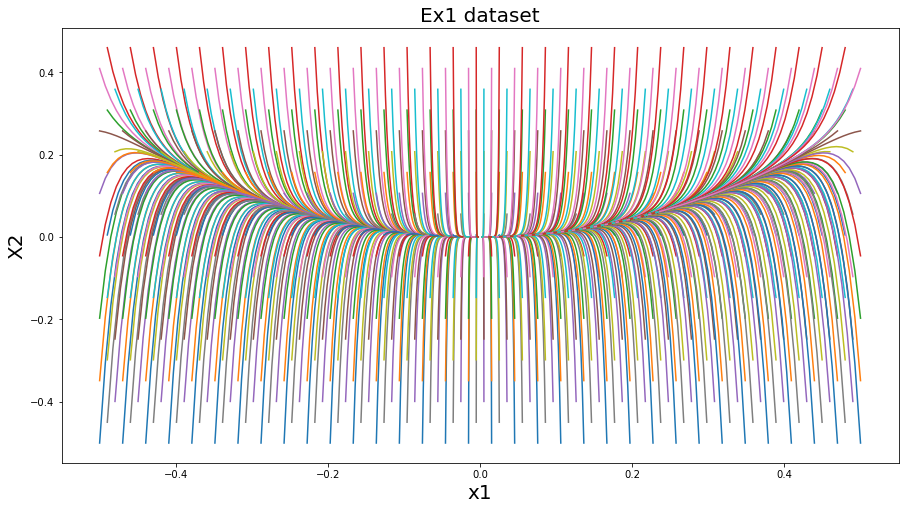

In [22]:
_ = plt.figure(figsize=(15,8))
for ii in np.arange(0, 10000, 15):
    x1 = data[ii, 0, :]
    x2 = data[ii, 1, :]
    _ = plt.plot(x1, x2, '-')
_ = plt.xlabel("x1", fontsize=20)
_ = plt.ylabel("X2", fontsize=20)
_ = plt.title("Ex1 dataset", fontsize=20)

In [23]:
def dmd_loss(x_data):
    x_minus = x_data[:, :-1]
    x_plus = x_data[:, 1:]

    U, S, Vt = np.linalg.svd(x_minus, full_matrices=True)

    I = np.identity(np.shape(Vt)[0])

    VVt = np.matmul(np.transpose(Vt), Vt)

    for_norm = np.linalg.norm(np.matmul(x_plus, (I - VVt)), ord='fro')
    
    return for_norm**2

In [24]:
for_vec_x = np.zeros(np.shape(data)[0])

In [25]:
for ii in range(0, np.shape(training_data.data_val)[0]):
    loss = dmd_loss(training_data.data_val[ii])
    for_vec_x[ii] = loss

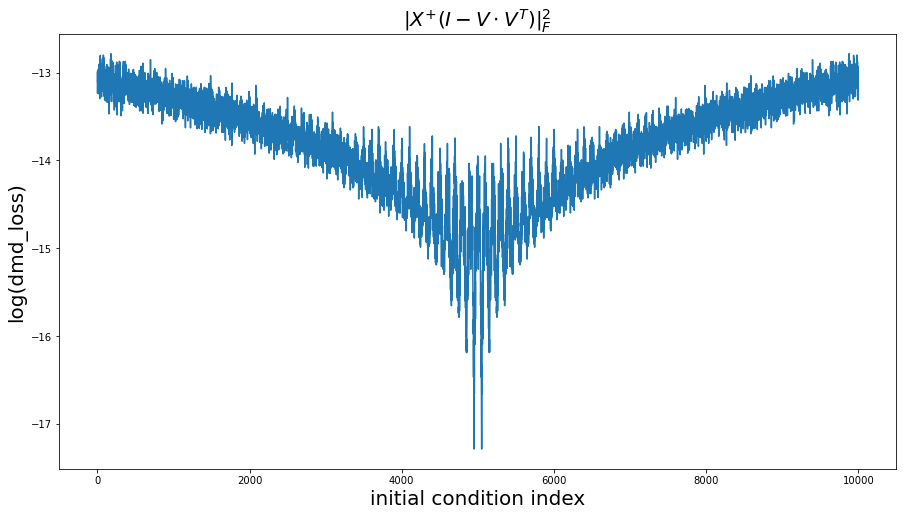

In [26]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(np.log10(for_vec_x))
_ = plt.ylabel("log(dmd_loss)", fontsize=20)
_ = plt.xlabel("initial condition index", fontsize=20)
_ = plt.title("$\| {X}^{+}( I - V \cdot V^{T})\| _{F}^{2}$", fontsize=20)


# y-coordinates. Analytic solution for the Koopman space. 

In [27]:
for_vec_y = np.zeros(np.shape(data)[0])
new_data = np.zeros((np.shape(data)[0], 3, np.shape(data)[-1]))

In [28]:
for ii in range(0, np.shape(training_data.data_val)[0]):
    x_data = training_data.data_val[ii]
    y_data = np.zeros((1+np.shape(x_data)[0], np.shape(x_data)[1]))
    
    x1 = x_data[0]
    x2 = x_data[1]
    x3 = x1**2
    
    y_data[0] = x1
    y_data[1] = x2
    y_data[2] = x3
    
    new_data[ii] = y_data
    
    loss = dmd_loss(y_data)
    for_vec_y[ii] = loss

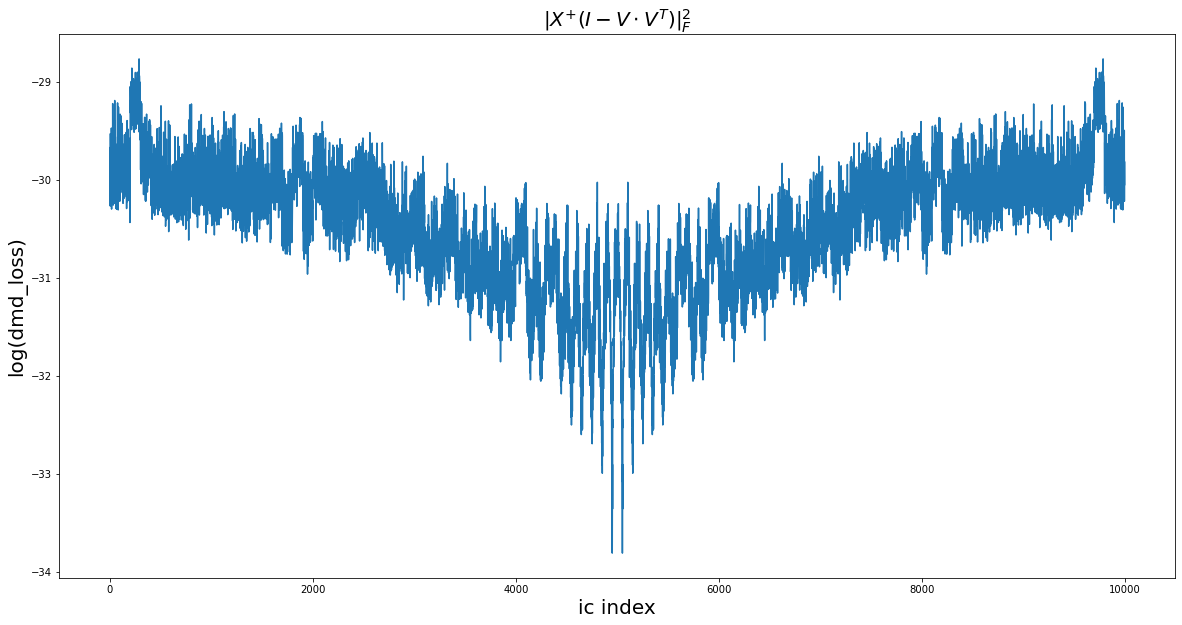

In [29]:
_ = plt.figure(figsize=(20,10))
_ = plt.plot(np.log10(for_vec_y[1:]))
_ = plt.ylabel("log(dmd_loss)", fontsize=20)
_ = plt.xlabel("ic index", fontsize=20)
_ = plt.title("$\| {X}^{+}( I - V \cdot V^{T})\| _{F}^{2}$", fontsize=20)

### Call the autoencoder simple machine to find the correct coordinate transformation. 

In [30]:
# Network Hyper Parameters.
hyp_params = dict()
hyp_params['num_t_steps'] = training_data.params['num_time_steps']
hyp_params['num_phys_dims'] = training_data.params["num_physical_dim"]
hyp_params['num_init_conds'] = training_data.params['num_initial_conditions']
hyp_params['batch_size'] = 256
hyp_params['num_epochs'] = 200

# Encoding/Decoding Layer Parameters.
hyp_params['num_en_layers'] = 4
hyp_params['num_en_neurons'] = 32
hyp_params['latent_dim'] = 2

hyp_params['activation'] = 'elu'
hyp_params['weight_initializer'] = 'he_uniform'
hyp_params['bias_initializer'] = 'he_uniform'

hyp_params['c1'] = 1  # coefficient auto-encoder loss.
hyp_params['c2'] = 1  # coefficient of dmd loss.
hyp_params['c3'] = 1  # coefficient of pred loss.

save_folder = "AeEx1_oct25"  # save results in the folder " Results/save_folder"-
# including loss curves and plot latent data.

# convert input data from numpy to tensorflow.
input_data = training_data.data_val
all_data = tf.data.Dataset.from_tensor_slices(input_data)

# shuffle the dataset and then divide to training vs testing data sets. 80% training .20% testing.
all_data_shuffle = all_data.shuffle(hyp_params['num_init_conds'], seed=42)
data_train = all_data_shuffle.take(int(0.8 * hyp_params['num_init_conds']))
data_test = all_data_shuffle.skip(int(0.8 * hyp_params['num_init_conds']))

# number of initial conditions in training and testing dataset.
hyp_params['num_init_conds_training'] = int(0.8 * hyp_params['num_init_conds'])
hyp_params['num_init_conds_test'] = hyp_params['num_init_conds'] - hyp_params['num_init_conds_training']

# initialize machine and loss objects.
myMachine = DMDMachine(hyp_params)
myLoss = LossFunction(hyp_params)

# Learning rate initialization.
hyp_params["initial_learning_rate"] = 3e-3  # MAJOR PARAMETER CHOICE
hyp_params["esteps"] = 80  # MAJOR PARAMETER CHOICE
count = 0

# clear previous run session.
tf.keras.backend.clear_session()

In [31]:
# create folder to save results.
create_new_folders(save_folder)

# save hyperparams in a json file.
save_hyp_params_in_json(hyp_params=hyp_params, json_file_path=os.path.join("results", save_folder, "hyp_params.txt"))

In [17]:

# initialize loss results (lists) as a function of epoch (iteration).
train_loss_results = []
test_loss_results = []

train_dmd_loss = []
test_dmd_loss = []

train_ae_loss = []
test_ae_loss = []

train_pred_loss = []
test_pred_loss = []

epoch = 0

while epoch < (hyp_params['num_epochs']):
    #start timer. 
    start_time = time.process_time()
    # save the total loss of the training data and testing data.
    epoch_loss_avg_train = tf.keras.metrics.Mean()
    epoch_loss_avg_test = tf.keras.metrics.Mean()

    # keep track of individual losses as well, aka dmd loss and ae loss.
    epoch_loss_dmd_train = tf.keras.metrics.Mean()
    epoch_loss_dmd_test = tf.keras.metrics.Mean()

    epoch_loss_ae_train = tf.keras.metrics.Mean()
    epoch_loss_ae_test = tf.keras.metrics.Mean()

    epoch_loss_pred_train = tf.keras.metrics.Mean()
    epoch_loss_pred_test = tf.keras.metrics.Mean()

    # Build out the batches within a given epoch.
    train_batch = data_train.shuffle(hyp_params['num_init_conds_training'], seed=42).batch(hyp_params["batch_size"],
                                                                                           drop_remainder=True)

    test_batch = data_test.shuffle(hyp_params['num_init_conds_test'], seed=42).batch(hyp_params["batch_size"],
                                                                                     drop_remainder=True)

    # Learning rate scheduling plan.  See Ch. 11 of O'Reilly.
    if epoch % hyp_params["esteps"] == 0:
        hyp_params['lr'] = (.2 ** count) * hyp_params["initial_learning_rate"]
        adam_optimizer = tf.keras.optimizers.Adam(hyp_params['lr'])
        count += 1

    # Iterate through all the batches within an epoch.
    for batch_training_data in train_batch:
        # normalize batch

        # Build terms that we differentiate (i.e. loss) and that we differentiate with respect to.
        with tf.GradientTape() as tape:
            # training=True is only needed if there are layers with different
            # behavior during training versus inference (e.g. Dropout).
            predictions_train = myMachine(batch_training_data)
            ae_loss = predictions_train[3]
            dmd_loss = predictions_train[2]
            pred_loss = predictions_train[5]

            loss_train = myLoss(batch_training_data, predictions_train)

            if epoch % 5 == 0:
                if abs((tf.reduce_min(predictions_train[1][:, 0, :]) - tf.reduce_max(
                        predictions_train[1][:, 0, :])).numpy()) < 0.3 \
                        or abs((tf.reduce_min(predictions_train[1][:, 1, :]) - tf.reduce_max(
                    predictions_train[1][:, 1, :])).numpy()) < 0.3 \
                        or abs((tf.reduce_min(predictions_train[0][:, 0, :]) - tf.reduce_max(
                    predictions_train[0][:, 0, :])).numpy()) < 0.3 \
                        or abs((tf.reduce_min(predictions_train[0][:, 1, :]) - tf.reduce_max(
                    predictions_train[0][:, 1, :])).numpy()) < 0.3:
                    print("restart initializers. ")
                    epoch = -1
                    tf.keras.backend.clear_session()
                    myMachine = DMDMachine(hyp_params)
                    myLoss = LossFunction(hyp_params)

        # Compute gradients and then apply them to update weights within the Neural Network
        gradients = tape.gradient(loss_train, myMachine.trainable_variables)
        adam_optimizer.apply_gradients([
            (grad, var)
            for (grad, var) in zip(gradients, myMachine.trainable_variables)
            if grad is not None
        ])

        # Keep track of the loss after each batch.
        epoch_loss_avg_train.update_state(loss_train)
        epoch_loss_ae_train.update_state(ae_loss)
        epoch_loss_dmd_train.update_state(dmd_loss)
        epoch_loss_pred_train.update_state(pred_loss)

    for batch_test_data in test_batch:
        predictions_test = myMachine(batch_test_data)
        dmd_test = predictions_test[2]
        ae_test = predictions_test[3]
        pred_test = predictions_test[5]

        loss_test = myLoss(batch_test_data, predictions_test)

        epoch_loss_avg_test.update_state(loss_test)
        epoch_loss_ae_test.update_state(ae_test)
        epoch_loss_dmd_test.update_state(dmd_test)
        epoch_loss_pred_test.update_state(pred_test)

    train_loss_results.append(epoch_loss_avg_train.result())
    test_loss_results.append(epoch_loss_avg_test.result())

    train_dmd_loss.append(epoch_loss_dmd_train.result())
    train_ae_loss.append(epoch_loss_ae_train.result())
    train_pred_loss.append(epoch_loss_pred_train.result())

    test_dmd_loss.append(epoch_loss_dmd_test.result())
    test_ae_loss.append(epoch_loss_ae_test.result())
    test_pred_loss.append(epoch_loss_pred_test.result())

    if epoch % 15 == 0:
        # save plots in results folder. Plot the latent space, ae_reconstruction, and input_batch.
        create_plots(batch_training_data, predictions_train, hyp_params, epoch, train_loss_results, save_folder, "train")
        create_plots(batch_test_data, predictions_test, hyp_params, epoch, test_loss_results, save_folder, "test")

    if epoch % 10 == 0:
        # plot latent, input and reconstructed ae latest batch data.
        try:
            print_status_bar(epoch, hyp_params["num_epochs"], epoch_loss_avg_train.result(),
                             epoch_loss_avg_test.result(), time.process_time() - start_time,
                             log_file_path=os.path.join("results", save_folder, "log.txt"))
        except Exception:
            print("print status failed.")

    if epoch % 50 == 0 and epoch != 0:
        # plot loss curves.
        create_plots_of_loss(train_dmd_loss, train_ae_loss, test_dmd_loss, test_ae_loss, train_pred_loss,
                             test_pred_loss, myLoss.c1, myLoss.c2, myLoss.c3, epoch, save_folder)

        # save loss curves in pickle files.
        try:
            save_loss_curves(train_loss_results, test_loss_results, train_dmd_loss, test_dmd_loss, train_ae_loss,
                             test_ae_loss, train_pred_loss, test_pred_loss,
                             file_path=os.path.join("results", "Loss", save_folder))
        except Exception:
            print("failed to save loss curves in pickle files. ")

        # save current machine.
        try:
            myMachine.autoencoder.save(os.path.join("models", save_folder), save_format='save_weights')
        except Exception:
            print("failed save machine. ")

    epoch += 1

# final summary of the network, again for diagnostic purposes.
myMachine.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models\AeEx1_oct25\assets
60/200 ,loss_train: 0

KeyboardInterrupt: 